# Deep Learning: Final Project

In [1]:
!pip install torch torchvision numpy matplotlib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\mrama\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import torchvision
import numpy as np
import torch
from torch.utils.data import DataLoader
import json
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

### Download pre-trained model

In [3]:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\mrama/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:50<00:00, 1.72MB/s]


### Setup dataset

In [4]:
!unzip -n TestDataSet.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
mean_norms = np.array([0.485, 0.456, 0.406], dtype=np.float32)
std_norms  = np.array([0.229, 0.224, 0.225], dtype=np.float32)
plain_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize(mean=mean_norms, std=std_norms) 
])

batch_size = 128
dataset_path = "./TestDataSet/TestDataSet"
dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=plain_transforms)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [6]:
# Load label mapping
with open(dataset_path + '/labels_list.json', "r") as f:
    label_list = json.load(f)
class_idx = [int(label.split(': ')[0]) for label in label_list]
class_label = [label.split(': ')[1] for label in label_list]

# map imagenet index to labels
imagenet_class_mapping = {idx: label for idx, label in zip(class_idx, class_label)}

# map dataset target to imagenet target
target_to_imagenet = {target: idx for target, idx in enumerate(class_idx)}

### Task 1: Evaluate pre-trained model

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pretrained_model = pretrained_model.to(device)
pretrained_model.eval()

top1_correct = 0
top5_correct = 0
total = 0

with torch.no_grad():
    for images, targets in dataloader:
        images = images.to(device)
        targets = targets.to(device)
        # map targets from test dataset to imagenet predictions
        imagenet_targets = torch.tensor(
            [target_to_imagenet[int(t)] for t in targets], device=device
        )

        # get preds
        outputs = pretrained_model(images)
        _, top5_preds = outputs.topk(5, dim=1)

        # Top-1 accuracy
        top1_correct += (top5_preds[:, 0] == imagenet_targets).sum().item()

        # Top-5 accuracy
        for i in range(images.size(0)):
            if imagenet_targets[i].item() in top5_preds[i]:
                top5_correct += 1

        total += images.size(0)

# Compute accuracy
top1_acc = top1_correct / total
top5_acc = top5_correct / total

print(f"Top-1 Accuracy: {top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy: {top5_acc * 100:.2f}%")

Top-1 Accuracy: 76.00%
Top-5 Accuracy: 94.20%


 Adversarial set generated: torch.Size([500, 3, 224, 224])
 Max L∞ distance = 0.0200 ≤ ε=0.02
 FGSM results (ε=0.02) — Top‑1 6.00%   Top‑5 35.60%


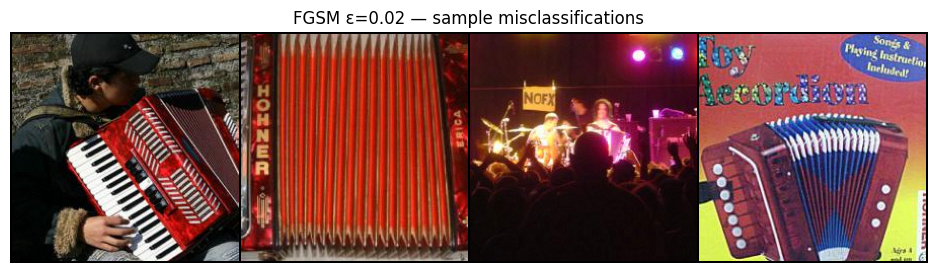

In [21]:
# Task 2
import math, pathlib, matplotlib.pyplot as plt
from torchvision.utils import make_grid

ε = 0.02                               # attack budget in normalised space
adv_root = pathlib.Path("AdvTestSet1") # where we'll save the perturbed images
adv_root.mkdir(exist_ok=True)

def fgsm_attack(x, y, model, eps):
    """
    One‑shot FGSM attack:  x→x′ = x + eps·sign(∇ₓL(x,y))
    ‑ x (B,C,H,W) : normalised input batch (requires_grad=False on entry)
    ‑ y           : ground‑truth ImageNet indices
    returns       : adversarial batch x′  (clipped to [0,1] after de‑norm)
    """
    x = x.clone().detach().to(device).requires_grad_(True)
    y = y.to(device)

    logits = model(x)
    loss = torch.nn.functional.cross_entropy(logits, y)
    loss.backward()

    x_adv = x + eps * x.grad.sign()
    # IMPORTANT: keep image in normalised range expected by the model.
    # The model was trained on mean/std‑normalised inputs, so we must
    # clamp AFTER normalisation limits have been reversed.
    mean = torch.tensor(mean_norms, device=device)[None, :, None, None]
    std  = torch.tensor(std_norms , device=device)[None, :, None, None]
    x_raw      = torch.clamp((x_adv * std) + mean, 0, 1)     # back to raw
    x_adv_norm = (x_raw - mean) / std                        # re‑normalise
    return x_adv_norm.detach(), x_raw.detach()

# -----------------------------------------------------------------------------
# Apply attack & write perturbed images beside originals
# -----------------------------------------------------------------------------
adv_imgs_raw, adv_imgs_norm, adv_targets = [], [], []
pretrained_model.eval()

with torch.no_grad():  # we compute gradients inside fgsm_attack
    pass

for images, targets in dataloader:
    # map our dataset’s folder‑targets → ImageNet indices
    imagenet_targets = torch.tensor(
        [target_to_imagenet[int(t)] for t in targets], device=device
    )
    x_adv_norm, x_adv_raw = fgsm_attack(images, imagenet_targets,
                                        pretrained_model, ε)
    adv_imgs_norm.append(x_adv_norm.cpu())
    adv_imgs_raw .append(x_adv_raw .cpu())
    adv_targets  .append(imagenet_targets.cpu())

    # Save individual files so that later tasks can reload them easily
    for j in range(x_adv_raw.size(0)):
        cls_name  = dataset.classes[targets[j]]
        cls_dir   = adv_root/cls_name
        cls_dir.mkdir(parents=True, exist_ok=True)
        img_path  = cls_dir/f"{len(list(cls_dir.iterdir())):05d}.png"
        torchvision.utils.save_image(x_adv_raw[j], img_path)

adv_imgs_norm = torch.cat(adv_imgs_norm)
adv_imgs_raw  = torch.cat(adv_imgs_raw)
adv_targets   = torch.cat(adv_targets)
print(" Adversarial set generated:", adv_imgs_norm.shape)

# -----------------------------------------------------------------------------
# Quick sanity check – verify ‖x′−x‖∞ ≤ ε exactly
# -----------------------------------------------------------------------------
orig_batches = []
for imgs,_ in dataloader:                                             # reload originals
    orig_batches.append(imgs)
orig = torch.cat(orig_batches)

l_inf = (adv_imgs_norm - orig).abs().max().item()
assert l_inf <= ε + 1e-6, f"L∞ distance {l_inf:.4f} > ε"
print(f" Max L∞ distance = {l_inf:.4f} ≤ ε={ε}")

# -----------------------------------------------------------------------------
# Evaluate ResNet‑34 on Adversarial Test Set 1
# -----------------------------------------------------------------------------
adv_loader = DataLoader(list(zip(adv_imgs_norm, adv_targets)),
                        batch_size=batch_size, shuffle=False)

top1, top5, n = 0, 0, 0
pretrained_model.eval()
with torch.no_grad():
    for x, y in adv_loader:
        x, y = x.to(device), y.to(device)
        logits   = pretrained_model(x)
        _, preds = logits.topk(5, dim=1)

        top1 += (preds[:,0] == y).sum().item()
        for i in range(x.size(0)):
            if y[i] in preds[i]:
                top5 += 1
        n += x.size(0)

adv_top1 = top1 / n
adv_top5 = top5 / n
print(f" FGSM results (ε={ε}) — Top‑1 {adv_top1*100:.2f}%   Top‑5 {adv_top5*100:.2f}%")

# -----------------------------------------------------------------------------
# Visualise 4 tell‑tale failures
# -----------------------------------------------------------------------------
def visualise_failures(num=4):
    failed = (preds[:,0] != y).nonzero(as_tuple=True)[0]
    if len(failed) == 0:
        print("No misclassified examples in the last batch!")
        return
    idxs = failed[:num].tolist()

    imgs_raw = adv_imgs_raw[idxs]
    figs     = make_grid(imgs_raw, nrow=num)
    plt.figure(figsize=(3*num,3))
    plt.imshow(figs.permute(1,2,0))
    plt.axis('off')
    plt.title(f"FGSM ε={ε} — sample misclassifications")
    plt.show()

visualise_failures(num=4)
